Aharon Rabson <br>
Air Pollution Analysis <br>

In [1]:
#Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("global air pollution dataset.csv")
df.head(10)

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good
5,United States of America,Punta Gorda,54,Moderate,1,Good,14,Good,11,Good,54,Moderate
6,Germany,Puttlingen,62,Moderate,1,Good,35,Good,3,Good,62,Moderate
7,Belgium,Puurs,64,Moderate,1,Good,29,Good,7,Good,64,Moderate
8,Russian Federation,Pyatigorsk,54,Moderate,1,Good,41,Good,1,Good,54,Moderate
9,Egypt,Qalyub,142,Unhealthy for Sensitive Groups,3,Good,89,Moderate,9,Good,142,Unhealthy for Sensitive Groups


In [3]:
# Step 1
# Checking for missing values/NaN's
missing_values_count = df.isnull().sum()
print("Missing values per column:\n", missing_values_count)

Missing values per column:
 Country               427
City                    1
AQI Value               0
AQI Category            0
CO AQI Value            0
CO AQI Category         0
Ozone AQI Value         0
Ozone AQI Category      0
NO2 AQI Value           0
NO2 AQI Category        0
PM2.5 AQI Value         0
PM2.5 AQI Category      0
dtype: int64


First, before any computations can be done on the dataset, we had to check if any elements were missing that would effect later code (in this case, to group by Country would clearly be problematic, unless we were to use a method to fill in the missing countries)

In [4]:
# Step 2
# Based off the large number of missing values for Country, I filled in with a placeholder
df['Country'] = df['Country'].fillna("Unknown")

Once we saw the large number of missing values for Country, we decided to put in placeholders to allow us to work with the data (until a further time when we might prefer to use imputation, however not as likely as this is categorical)

In [5]:
# Step 3
# Standardising the text fields
# Standardizing text data to all lower case for consistency in the location
df['City'] = df['City'].str.lower()
df['Country'] = df['Country'].str.lower()

# Converting all categories to uppercase
df['AQI Category'] = df['AQI Category'].str.lower()
df['CO AQI Category'] = df['CO AQI Category'].str.lower()
df['Ozone AQI Category'] = df['Ozone AQI Category'].str.lower()
df['NO2 AQI Category'] = df['NO2 AQI Category'].str.lower()
df['PM2.5 AQI Category'] = df['PM2.5 AQI Category'].str.lower()
df.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,russian federation,praskoveya,51,moderate,1,good,36,good,0,good,51,moderate
1,brazil,presidente dutra,41,good,1,good,5,good,1,good,41,good
2,italy,priolo gargallo,66,moderate,1,good,39,good,2,good,66,moderate
3,poland,przasnysz,34,good,1,good,34,good,0,good,20,good
4,france,punaauia,22,good,0,good,22,good,0,good,6,good


We first wanted that all the Country and City fields would be consistent, we left it with lowercase for presentability. To ensure consistency in the rest, we also converted all other text data to the same case. This is useful if we will perform text-based operations or merging with other data sources that might have case sensitivity later on.

In [6]:
# Step 4
# Removing duplicates
df = df.drop_duplicates()

To prevent skewing/faults in our data when we move on to the analysis, we made sure there would be no duplicate values in the dataset. It can be a common error, especially if data was manually entered.

In [7]:
# Step 5
# Finding Outliers
# Using IQR to identify outliers in the 'AQI Value' column
Q1 = df['AQI Value'].quantile(0.25)
Q3 = df['AQI Value'].quantile(0.75)
IQR = Q3 - Q1

# Filtering out outliers
df = df[~((df['AQI Value'] < (Q1 - 1.5 * IQR)) | (df['AQI Value'] > (Q3 + 1.5 * IQR)))]

We filtered out outliers as they will cause bias in data analysis we do later on, especially in modelling the data. We chose to find outliers as opposed to simply cutting out entries that are not in the normal range of AQI (0-500) as this method helps preserve the natural variability of data, which could be crucial for understanding underlying phenomena.

In [8]:
# Step 6
# Feature Engineering
# Creating a combined pollution index
df['Combined Pollution Index'] = (df['CO AQI Value'] + df['Ozone AQI Value'] + df['NO2 AQI Value'] + df['PM2.5 AQI Value']) / 4

A combined pollution index might give further predictive power or additional insight into the dataset, possibly also a relationship to the general AQI Value of each city

In [9]:
pip install fuzzywuzzy[speedup]

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Step 7
# Fuzzy matching the countries

import pandas as pd
from fuzzywuzzy import process

import pycountry

# Fetching the list of all country names
countries = [country.name for country in pycountry.countries]

# Function to apply fuzzy matching
def match_country(country, allowed_countries):
    # Returns the closest match in allowed_countries
    matched_country, score = process.extractOne(country, allowed_countries)
    # set a threshold for score
    return matched_country if score >= 75 else country  # Using a threshold score of 75

# Apply fuzzy matching to the 'Country' column
df['Country'] = df['Country'].apply(lambda x: match_country(x, countries))

# Display the corrected DataFrame to verify changes
print(df[['Country']].drop_duplicates())  # Showing unique country names to check the results

                     Country
0         Russian Federation
1                     Brazil
2                      Italy
3                     Poland
4                     France
...                      ...
16001             Seychelles
17025    Palestine, State of
21179                  Yemen
22311  Saint Kitts and Nevis
22749                 Monaco

[168 rows x 1 columns]


In [12]:
# Displaying the corrected Dataframe
unique_countries = df['Country'].unique()
print(unique_countries)

['Russian Federation' 'Brazil' 'Italy' 'Poland' 'France' 'United States'
 'Germany' 'Belgium' 'China' 'Netherlands' 'North Macedonia' 'India'
 'Colombia' 'Romania' 'Indonesia' 'Finland' 'South Africa'
 'United Kingdom' 'Tanzania, United Republic of' 'Egypt' 'Haiti' 'Somalia'
 'Philippines' 'Latvia' 'Chad' 'New Zealand' 'Tunisia' 'Viet Nam' 'Mexico'
 'Japan' 'El Salvador' 'Bulgaria' 'Nigeria' 'South Sudan' 'Guatemala'
 'Ireland' 'Turkmenistan' 'Peru' 'Congo, The Democratic Republic of the'
 'Canada' 'Switzerland' 'Denmark' 'Cameroon' 'Australia' 'Portugal'
 "Côte d'Ivoire" 'Sweden' 'Ethiopia' 'Thailand' 'Hungary'
 'Iran, Islamic Republic of' 'Kazakhstan' 'Israel' 'Spain'
 'Papua New Guinea' 'Madagascar' 'Lithuania' 'Ghana' 'Azerbaijan'
 'Armenia' 'Ukraine' 'Malaysia' 'Serbia' 'Slovakia' 'Gambia' 'Pakistan'
 'Ecuador' 'Bosnia and Herzegovina' 'Czechia' 'Argentina'
 'Dominican Republic' 'Guinea' 'Bolivia, Plurinational State of'
 'Bangladesh' 'Sudan' 'Chile' 'Panama' 'Congo' 'Kyrgyzstan' 

In the above steps, various data wrangling steps were undertaken to enhance the usability and reliability of our global air pollution dataset. Changes included handling missing values, standardizing textual data for consistency, removing duplicates and  identifying and removing outliers. Additionally, fuzzy matching techniques were applied to standardize country names, which potentially contained minor discrepancies such as misspellings or alternative naming conventions.

While our dataset does not directly fall under stringent regulatory guidelines specific to personal data, it's crucial to consider the broader ethical implications of accuracy and representation in environmental data reporting. The transformations could introduce biases—especially through the assumptions made during data imputation and standardization. For instance, replacing missing country names with a generic label like "Unknown" or assumptions in fuzzy matching could misrepresent or oversimplify the data's factual content. 
The data was sourced from a publicly accessible Kaggle dataset, with the data collected from EliChens, so it's fair to assume that the data collection complied with relevant environmental data collection standards and ethical guidelines. However, the modifications applied in data wrangling could still risk misrepresenting the original data's precision or intent. For example, any normalization or filling of missing values might obscure true environmental conditions or the severity of pollution in specific locations.

To mitigate these concerns, it is crucial for us to ensure full transparency about the modifications applied, maintain an audit trail from the original data through to the transformed dataset, and disclose any assumptions made during the cleaning process. Also verifying changes against other reputable sources or supplementary data from EliChens could help validate the modifications. Providing access to both the unmodified and modified dataset versions would allow users to understand the impact of data wrangling steps and assess the data's integrity independently, fostering trust and reliability in the analysis derived from this dataset.

# Milestone 3

In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Pulling the sites for the most polluted countries and also for the top 50 most polluted cities, as I'm not sure which way
# the analysis will lean towards in the next steps of the project.

# Possibly can switch to the live table which provides AQI instead of PM2.5 https://www.iqair.com/world-air-quality-ranking

# URL of the page to scrape
url = 'https://www.iqair.com/world-most-polluted-countries'
url2 = 'https://www.iqair.com/world-most-polluted-cities'

# Send a GET request
response = requests.get(url)
response2 = requests.get(url2)

if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')
else:
    print("Failed to retrieve the webpage")
    soup = None

if response2.status_code == 200:
    # Parse the HTML content
    soup2 = BeautifulSoup(response2.text, 'html.parser')
else:
    print("Failed to retrieve the webpage")
    soup2 = None

In [14]:
# Finding the table, assuming there is only one table on the page
table = soup.find('table')
rows = table.find_all('tr')

# Initialize list to store row data
data = []
for row in rows:
    # Get all cells in the row
    cells = row.find_all(['th', 'td'])
    row_data = [cell.text.strip() for cell in cells]
    data.append(row_data)

# Create a DataFrame with the correct column headers
country_df = pd.DataFrame(data[1:], columns=data[0])  # first row as header
print(country_df.head())


  Rank Country/Region  2023  2022  2021  2020  2019  2018     Population
0    1     Bangladesh  79.9  65.8  76.9  77.1  83.3  97.1    169,356,251
1    2       Pakistan  73.7  70.9  66.8    59  65.8  74.3    231,402,117
2    3          India  54.4  53.3  58.1  51.9  58.1  72.5  1,407,563,842
3    4     Tajikistan    49    46  59.4  30.9    --    --      9,750,064
4    5   Burkina Faso  46.6    63    --    --    --    --     22,100,683


In [15]:
# Finding the table, assuming there is only one table on the page
# However, there are multiple pages of the continuation of the table, so I have update the code to run through
# a few of them

# Function to scrape a single page
def scrape_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table')
    rows = table.find_all('tr')

    # Initialize list to store row data
    data = []
    for row in rows:
        # Get all cells in the row
        cells = row.find_all(['th', 'td'])
        row_data = [cell.text.strip() for cell in cells]
        data.append(row_data)

    return data

# Function to scrape multiple pages
def scrape_multiple_pages(base_url, num_pages):
    all_data = []
    for page in range(1, num_pages + 1):
        url = f"{base_url}&page={page}"
        page_data = scrape_page(url)
        if page == 1:
            headers = page_data[0]
        all_data.extend(page_data[1:])  # Skip header row for subsequent pages
    return headers, all_data

# Base URL
base_url = 'https://www.iqair.com/world-most-polluted-cities?sort=-rank&perPage=50&cities='
num_pages = 30  # Number of pages to scrape

# Scrape data from multiple pages
headers, all_data = scrape_multiple_pages(base_url, num_pages)

# Create DataFrame
top_city_df = pd.DataFrame(all_data, columns=headers)

print (top_city_df)

      Rank                       City   2023    Jan    Feb    Mar    Apr  \
0        1           Begusarai, India  118.9   31.2  235.3  156.8    113   
1        2            Guwahati, India  105.4  220.2  168.1  129.2  112.2   
2        3               Delhi, India  102.1  171.8  114.3   77.4     71   
3        4           Mullanpur, India  100.4  106.3  123.7   78.1   56.6   
4        5           Lahore, Pakistan   99.5  143.2  117.3   73.8   52.9   
...    ...                        ...    ...    ...    ...    ...    ...   
1495  1496             Harish, Israel   16.8   14.4   12.6   14.6   14.2   
1496  1497     Kiryat Malakhi, Israel   16.8   17.3   13.7   15.6   15.2   
1497  1498    Settimo Milanese, Italy   16.8     --     --     --   13.2   
1498  1499         Nindiri, Nicaragua   16.8    9.6    9.8   15.8   28.2   
1499  1500  Popesti-Leordeni, Romania   16.8   22.7   26.9   22.6   15.7   

        May   Jun   Jul  ...   Sep    Oct    Nov    Dec   2022  2021  2020  \
0     109

In [16]:
# Step 1: Checking for missing values

missing_values_count = country_df.isnull().sum()
print("Missing values (in Country DF) per column:\n", missing_values_count)

missing_values_count2 = top_city_df.isnull().sum()
print("Missing values (in City DF) per column:\n", missing_values_count2)

Missing values (in Country DF) per column:
 Rank              0
Country/Region    0
2023              0
2022              0
2021              0
2020              0
2019              0
2018              0
Population        0
dtype: int64
Missing values (in City DF) per column:
 Rank    0
City    0
2023    0
Jan     0
Feb     0
Mar     0
Apr     0
May     0
Jun     0
Jul     0
Aug     0
Sep     0
Oct     0
Nov     0
Dec     0
2022    0
2021    0
2020    0
2019    0
2018    0
2017    0
dtype: int64


First, before any computations can be done on the dataset, we had to check if any elements were missing that would effect later code in grouping, comparing entries etc.

In [17]:
# Step 2: Converting to floats the numerical datatypes for later calculations 
# Step 3: Converting unavailable data (entered as '--') into NaN

# Converts numerical data from string to floats and NaN's
numerical_columns = country_df.columns[2:-1]  # Exclude 'Rank' and 'Country/Region', and 'Population' from the end
country_df[numerical_columns] = country_df[numerical_columns].replace(',', '', regex=True)\
                                                .replace('--', np.nan, regex=True).astype(float)

# Converts numerical data from string to floats and NaN's
numerical_columns2 = top_city_df.columns[2:]  # Exclude 'Rank' and 'City'
top_city_df[numerical_columns2] = top_city_df[numerical_columns2].replace(',', '', regex=True)\
                                                .replace('--', np.nan, regex=True).astype(float)

# Clean 'Population' column also to a numerical datatype (int)
country_df['Population'] = country_df['Population'].replace(',', '', regex=True).astype(int)


We converted all the datapoints in each row into numeric form, to make it easier later on to possibly do modelling or calculations, which would have been more difficult, if not even unviable, with them still stored as strings.

In [18]:
# Step 4: Splitting the City field into both City and Country in top_50 df

top_city_df['City'] = top_city_df['City'].str.strip()  # Remove any leading/trailing whitespace

# Using lamda functions to split into two unique columns
top_city_df['Country'] = top_city_df['City'].apply(lambda x: x.split(',')[-1].strip())
top_city_df['City'] = top_city_df['City'].apply(lambda x: ','.join(x.split(',')[:-1]).strip())

# Now printing to verify the changes
print(top_city_df[['City', 'Country']].head())


        City   Country
0  Begusarai     India
1   Guwahati     India
2      Delhi     India
3  Mullanpur     India
4     Lahore  Pakistan


In the top_city df, the city column stored both city and country, we split that into two individual fields, which will allow comparisons and grouping to be proficient, specifically when we later on merge the datasets and the API.

In [19]:
#Step 5: Standardising all strings for future comparison and analysis

country_df['Country/Region'] = country_df['Country/Region'].str.lower()

top_city_df['City'] = top_city_df['City'].str.lower()  # Converts city names to lower case
top_city_df['Country'] = top_city_df['Country'].str.lower()  # Converts country names to lower case


We standardised both location strings, again for proficiency later on when comparing data entries and allowing matches to be found ( without simple errors such as London and london preventing a match)

In [20]:
# Step 6: Checking for, and dropping, any duplicates

country_df.drop_duplicates(subset =['Country/Region', '2023'], inplace = True)

top_city_df.drop_duplicates(subset=['City', 'Country', '2023'], inplace = True)

In case there was human error involved that caused the same entry to be entered multiple times, we dropped all duplicates from the dataset, basing it off the location as these datasets are only meant to contain one entry for the summation for each location's pollution levels.

In [21]:
# Step 7: Feature engineering

top_city_df['Average_PM2.5_3yrs'] = top_city_df[['2021', '2022', '2023']].mean(axis=1)
top_city_df['AQI_Trend'] = (top_city_df['2023'] - top_city_df['2020']) / top_city_df['2020']

# Display the new features
print(top_city_df[['City', 'Average_PM2.5_3yrs', 'AQI_Trend']].head())

        City  Average_PM2.5_3yrs  AQI_Trend
0  begusarai           54.500000        NaN
1   guwahati           69.833333   0.697262
2      delhi           97.033333   0.214031
3  mullanpur          142.950000        NaN
4     lahore           94.466667   0.256313


We used feature engineering to create a new column based off the average pollution levels over the last three years along with a trend, these two combined will allow deeper insights into the overall pollution and its trajectory in possible future analysis

In [22]:
#Step 8: Categorising data
 
def categorize_pm25(pm25):
    if pm25 <= 5:
        return 'OK'
    elif pm25 <= 25:
        return 'Moderate'
    elif pm25 <= 50:
        return 'High'
    else:
        return 'Very High'

top_city_df['PM2.5_Category'] = top_city_df['2023'].apply(categorize_pm25)

# Display the categorized data
print(top_city_df[['City', '2023', 'PM2.5_Category']].head())

        City   2023 PM2.5_Category
0  begusarai  118.9      Very High
1   guwahati  105.4      Very High
2      delhi  102.1      Very High
3  mullanpur  100.4      Very High
4     lahore   99.5      Very High


This feature was added for possible future analysis to help visualise and understand the levels of pollution measured, by grouping according to the WHO guidelines (In our particular analysis it will not be used any further as we only pulled the top 50 entries out of 1500, as such all will be expected to be Very High)

Note for future analysis:

Further steps would be recommended at a more advanced level, such as using interpolation to replace the NaN values with imputated values, to possibly do data integrity checks, to use normalisation etc.

During the data wrangling of the datasets from IQAir, which specifically measure PM2.5 levels, several transformations were made to improve the data's utility and reliability. These changes included the extraction and separation of city and country information into distinct fields to enhance granularity, and the conversion of textual data into numerical formats to enable quantitative analysis and missing values were converted into correct datatype (NaN) to maintain dataset completeness.

While handling this type of environmental data, it's essential to consider the ethical implications, especially given the health implications associated with PM2.5 exposure. The transformations introduced could potentially create risks such as misrepresentation of air quality trends or biases in data interpretation, particularly if outlier removal or data imputation were handled improperly. Furthermore, they could potentially influence public perception and policy decisions regarding air quality management. 
Therefore, assumptions in handling missing data and the methods used for categorizing PM2.5 concentrations need to be clearly justified and documented to avoid misrepresentations, however, there was no assumptions made up to now in our analysis of the data, thus requiring no further documentation.

The data sourced from IQAir, known for its credibility in environmental monitoring, suggests ethical data collection practices. However, to mitigate any adverse implications arising from the data transformations, it is crucial to maintain transparency about the methodologies used in data processing. This includes providing detailed documentation of all data cleaning steps and assumptions, offering access to both the original and transformed datasets for verification purposes, and using robust statistical methods to minimize biases. 
Ensuring that all data transformations and analyses are conducted in an open and reproducible manner will help uphold the integrity of the research and its conclusions, fostering trust and informed decision-making among stakeholders. 
This approach ensures that the data remains trustworthy and that subsequent analyses and recommendations based on this data are sound and responsibly made.

In [23]:
# Necessary imports
import requests
import pandas as pd
import numpy as np
import datetime

In [ ]:
# API key for OpenWeatherMap's One Call API
API_KEY_ONE_CALL = "insert your API Key here"

In [25]:
# Function to fetch latitude and longitude based on city or zip code using OpenWeatherMap's One Call API.

    
def get_lat_lon_city(query, query_type):
    endpoint = ""
    if query_type == 'city':
        city, country = query.split(',')
        endpoint = f"http://api.openweathermap.org/geo/1.0/direct?q={city},{country}&appid={API_KEY_ONE_CALL}"
    elif query_type == 'zip':
        endpoint = f"http://api.openweathermap.org/geo/1.0/zip?zip={query},&appid={API_KEY_ONE_CALL}"

    try:
        response = requests.get(endpoint)
        response.raise_for_status()
        data = response.json()
        if data:
            if query_type == 'city':
                return data[0]['lat'], data[0]['lon'], data[0]['name'], data[0]['country']
            elif query_type == 'zip':
                return data['lat'], data['lon'], data['name'], data['country']
        else:
            print(f"No data found for {query}. Please ensure the city or zip code is correct.")
            return None, None, None, None
    except requests.RequestException as e:
        print(f"Error fetching latitude and longitude for {query}: {e}")
        return None, None, None, None

In [26]:
# Function to fetch weather data based on latitude and longitude using OpenWeatherMap's One Call API.
def get_weather_data(lat, lon, unit='metric'):
    endpoint = f"https://api.openweathermap.org/data/2.5/onecall?lat={lat}&lon={lon}&exclude=minutely,hourly,alerts&units={unit}&appid={API_KEY_ONE_CALL}"
    try:
        response = requests.get(endpoint)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching weather data: {e}")
        return None

In [27]:
# Function to fetch pollution data based on latitude and longitude using OpenWeatherMap's Air Pollution API.
def get_pollution_data(lat, lon):
    endpoint = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={API_KEY_ONE_CALL}"
    try:
        response = requests.get(endpoint)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching pollution data: {e}")
        return None

In [28]:
# Function to display weather and pollution data in a readable format.
def display_data(weather_data, pollution_data, unit='metric'):
    symbols = {
        'metric': '°C',
        'imperial': '°F',
        'standard': 'K'
    }
    
    current_data = weather_data['current']
    daily_data = weather_data['daily'][0]
    
    current_temp = current_data['temp']
    feels_like = current_data['feels_like']
    low_temp = daily_data['temp']['min']
    high_temp = daily_data['temp']['max']
    pressure = current_data['pressure']
    humidity = current_data['humidity']
    description = current_data['weather'][0]['description']
    
    print(f"Current Temperature: {current_temp}{symbols[unit]}")
    print(f"Feels Like: {feels_like}{symbols[unit]}")
    print(f"Low Temperature: {low_temp}{symbols[unit]}")
    print(f"High Temperature: {high_temp}{symbols[unit]}")
    print(f"Pressure: {pressure} hPa")
    print(f"Humidity: {humidity}%")
    print(f"Description: {description.capitalize()}")
    
    if pollution_data:
        pm2_5 = pollution_data['list'][0]['components']['pm2_5']
        pm10 = pollution_data['list'][0]['components']['pm10']
        co = pollution_data['list'][0]['components']['co']
        no = pollution_data['list'][0]['components']['no']
        no2 = pollution_data['list'][0]['components']['no2']
        o3 = pollution_data['list'][0]['components']['o3']
        so2 = pollution_data['list'][0]['components']['so2']
        nh3 = pollution_data['list'][0]['components']['nh3']
        
        print("\nPollution Data:")
        print(f"PM2.5: {pm2_5} µg/m³")
        print(f"PM10: {pm10} µg/m³")
        print(f"CO: {co} µg/m³")
        print(f"NO: {no} µg/m³")
        print(f"NO2: {no2} µg/m³")
        print(f"O3: {o3} µg/m³")
        print(f"SO2: {so2} µg/m³")
        print(f"NH3: {nh3} µg/m³")

In [29]:
# Example usage
query = "New York,US"
query_type = "city"
lat, lon, city_name, country = get_lat_lon_city(query, query_type)

if lat and lon:
    weather_data = get_weather_data(lat, lon)
    pollution_data = get_pollution_data(lat, lon)
    if weather_data and pollution_data:
        print("Weather and pollution data fetched successfully.")
    else:
        print("Error fetching weather or pollution data.")
else:
    print("No data found for the specified location.")


Weather and pollution data fetched successfully.


In [30]:
if weather_data and pollution_data:
    print(f"Weather and pollution data for {city_name}, {country}:")
    display_data(weather_data, pollution_data)

    # Step 1: Normalize JSON response into DataFrame
    df_weather = pd.json_normalize(weather_data['current'])
    df_pollution = pd.json_normalize(pollution_data['list'][0]['components'])

    # Step 2: Replace headers to more readable format
    df_weather.rename(columns={
        'temp': 'Temperature',
        'feels_like': 'Feels_Like',
        'pressure': 'Pressure',
        'humidity': 'Humidity',
        'weather[0].description': 'Description'
    }, inplace=True)

    # Step 3: Convert Unix timestamps to human-readable dates
    df_weather['dt'] = pd.to_datetime(df_weather['dt'], unit='s')
    
    # Check if 'Description' column exists before accessing it
    if 'Description' in df_weather.columns:
        df_weather = df_weather[['dt', 'Temperature', 'Feels_Like', 'Pressure', 'Humidity', 'Description']]
    else:
        df_weather = df_weather[['dt', 'Temperature', 'Feels_Like', 'Pressure', 'Humidity']]

    # Step 4: Identify and remove outliers in temperature data
    def identify_outliers(df, column):
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    outliers = identify_outliers(df_weather, 'Temperature')
    df_weather = df_weather[~df_weather.index.isin(outliers.index)]

    # Step 5: Fix casing of the 'Description' column
    if 'Description' in df_weather.columns:
        df_weather['Description'] = df_weather['Description'].str.capitalize()
    
    # Step 6: See if API returned empty values
    missing_api_values = df_pollution.isnull().sum()
    print(missing_api_values)

    # Step7: Fill missing values with the median
    df_pollution.fillna(df_pollution.median(), inplace=True)

    # Step 8 Convert pollution data from µg/m³ to mg/m³
    df_pollution_mg = df_pollution / 1000

    # Step 9: Identifying and removing outliers in pollution data with outlier func
    for column in df_pollution.columns:
        outliers = identify_outliers(df_pollution, column)
        df_pollution = df_pollution[~df_pollution.index.isin(outliers.index)]

    # Step 10: Apply normalization only if there are multiple rows
    if len(df_pollution) > 1:
        df_pollution_normalized = (df_pollution - df_pollution.min()) / (df_pollution.max() - df_pollution.min())
        print("\nNormalized Pollution Data:")
        print(df_pollution_normalized)
    else:
        print("\nPollution data normalization skipped due to single-row DataFrame.")
    
    # Displaying the processed DataFrames
    print("\nProcessed Weather Data:")
    print(df_weather)
    print("\nProcessed Pollution Data:")
    print(df_pollution)
    print("\nPollution Data in mg/m³:")
    print(df_pollution_mg)

Weather and pollution data for New York County, US:
Current Temperature: 28.78°C
Feels Like: 27.54°C
Low Temperature: 17.05°C
High Temperature: 28.78°C
Pressure: 1020 hPa
Humidity: 27%
Description: Clear sky

Pollution Data:
PM2.5: 2.95 µg/m³
PM10: 3.66 µg/m³
CO: 208.62 µg/m³
NO: 0.86 µg/m³
NO2: 4.63 µg/m³
O3: 118.73 µg/m³
SO2: 1.97 µg/m³
NH3: 0.5 µg/m³
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64

Pollution data normalization skipped due to single-row DataFrame.

Processed Weather Data:
                   dt  Temperature  Feels_Like  Pressure  Humidity
0 2024-06-01 19:19:35        28.78       27.54      1020        27

Processed Pollution Data:
       co    no   no2      o3   so2  pm2_5  pm10  nh3
0  208.62  0.86  4.63  118.73  1.97   2.95  3.66  0.5

Pollution Data in mg/m³:
        co       no      no2       o3      so2    pm2_5     pm10     nh3
0  0.20862  0.00086  0.00463  0.11873  0.00197  0.00295  0.00366  0.0005


Below is the explanation of each step, which was not done in seperate cells as all are dependant on the 'if' statement passing through

1.Normalize JSON response into DataFrame
Normalizing the JSON response into a pandas DataFrame structures the nested JSON data into a tabular format, making it easier to manipulate and analyze. This step converts the raw JSON data into a format suitable for data analysis.

2.Replace headers to more readable format
Renaming our columns to more readable names improves the understandability of the data. This makes the DataFrame more intuitive and easier to work with, especially when sharing with others or performing further analysis.

3.Convert Unix timestamps to human-readable dates
Converting Unix timestamps to human-readable dates allows for easier interpretation and analysis of the time-related data. This step ensures that the dates are in a format that is comprehensible to users.

4.Identify and remove outliers in temperature data
Identifying and removing outliers ensures that the data is not skewed by extreme values, which can distort the results of analysis. This step improves the reliability of the statistical analysis by excluding anomalous data points.

5.Fix casing of the 'Description' column
Standardizing the text casing in the 'Description' column ensures consistency and improves the readability of the data. This step helps maintain uniformity in the dataset, making it easier to interpret text data.

6.See if API returned empty values
Checking for missing values helps identify gaps in the data that need to be addressed. This step is crucial for ensuring the completeness and accuracy of the dataset before performing further analysis.

7.Fill missing values with the median
Filling missing values with the median is a common data imputation method that minimizes the impact of missing data. The median is used because it is less sensitive to outliers compared to the mean, providing a more robust central value.

8.Convert pollution data from µg/m³ to mg/m³
Converting the units from µg/m³ to mg/m³ provides an alternative representation of the pollution data, which may be more suitable for certain analyses or comparisons. This step enhances the flexibility of the data usage.

9.Identify and remove outliers in pollution data with outlier function
Identifying and removing outliers in the pollution data ensures that the analysis is not affected by extreme values, which can lead to misleading conclusions. This step is essential for maintaining the integrity of the data analysis.

10.Apply normalization only if there are multiple rows
Normalizing the pollution data scales the values to a common range, facilitating comparisons between different variables. This step is applied only if there are multiple rows to ensure meaningful normalization.

In the process of data wrangling for the weather and pollution data sourced from the OpenWeatherMap API, various transformations were applied to ensure the data's usability and integrity. These transformations included normalizing the JSON response into a pandas DataFrame, replacing raw headers with more readable ones, converting Unix timestamps to human-readable dates, identifying and removing outliers, and standardizing text casing for consistency. Additionally, detailed pollution data was extracted to provide comprehensive insights and normalization was used. 

While handling this data, it is crucial to consider the ethical implications, particularly the potential impact of these transformations on public perception and policy decisions. The assumptions made during data cleaning, such as the removal of outliers and the handling of missing values, were documented to maintain transparency. The data, sourced from OpenWeatherMap, a reputable provider, ensures a level of credibility and ethical data collection practices. However, to mitigate any adverse implications, it is essential to maintain transparency in data processing and provide access to both raw and processed data forms. This approach ensures that the data remains trustworthy, fostering informed decision-making and maintaining public trust. Additionally, care must be taken to ensure that any derived insights do not mislead or cause unnecessary alarm among the public. Ensuring data privacy and adhering to any legal guidelines surrounding environmental data use is also critical.

Overall, our EDA on the API maintains the theme of the previous two data sources, meaning the sources allow access to their datasets and the subject of the data is one with comparatively small implications in the field of ethical data handling. The one major difference that should be kept in mind is the API's data is based off of current events, as such the data can provide misleading information if not updated before each use with a new request.

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [32]:
# Step 1: Storing each dataset into a SQLite database
conn = sqlite3.connect('air_quality_data.db')

In [33]:
# Load your datasets (assuming they are already cleaned and named as per your notebook)
df_csv = df  # global air pollution dataset
df_website = country_df  # country data from IQAir
df_topcity = top_city_df  # city data from IQAir
df_api = df_pollution  # pollution data from API

In [34]:
# Step 1: Store each dataset into an SQLite database
# This command creates a new SQLite database file named 'air_quality_data.db' if it does not already exist.
conn = sqlite3.connect('air_quality_data.db')

In [35]:
# Check the DataFrames before writing to the database
print("CSV DataFrame head:")
print(df_csv.head())
print("Website DataFrame head:")
print(df_website.head())
print("Top City DataFrame head:")
print(df_topcity.head())
print("API DataFrame head:")
print(df_api.head())

CSV DataFrame head:
              Country              City  AQI Value AQI Category  CO AQI Value  \
0  Russian Federation        praskoveya         51     moderate             1   
1              Brazil  presidente dutra         41         good             1   
2               Italy   priolo gargallo         66     moderate             1   
3              Poland         przasnysz         34         good             1   
4              France          punaauia         22         good             0   

  CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
0            good               36               good              0   
1            good                5               good              1   
2            good               39               good              2   
3            good               34               good              0   
4            good               22               good              0   

  NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category  \
0 

In [36]:
# Storing individual datasets as tables in SQLite
df_csv.to_sql('csv_data', conn, if_exists='replace', index=False)
df_website.to_sql('website_data', conn, if_exists='replace', index=False)
df_topcity.to_sql('topcity_data', conn, if_exists='replace', index=False)
df_api.to_sql('api_data', conn, if_exists='replace', index=False)

1

In [37]:
# Verify tables
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", tables)

Tables in the database: [('csv_data',), ('website_data',), ('topcity_data',), ('api_data',)]


In [38]:
# Verify data in each table
print("\nCSV Data Table:")
print(pd.read_sql_query("SELECT * FROM csv_data LIMIT 5;", conn))

print("\nWebsite Data Table:")
print(pd.read_sql_query("SELECT * FROM website_data LIMIT 5;", conn))

print("\nTop city Data Table:")
print(pd.read_sql_query("SELECT * FROM topcity_data LIMIT 5;", conn))

print("\nAPI Data Table:")
print(pd.read_sql_query("SELECT * FROM api_data LIMIT 5;", conn))


CSV Data Table:
              Country              City  AQI Value AQI Category  CO AQI Value  \
0  Russian Federation        praskoveya         51     moderate             1   
1              Brazil  presidente dutra         41         good             1   
2               Italy   priolo gargallo         66     moderate             1   
3              Poland         przasnysz         34         good             1   
4              France          punaauia         22         good             0   

  CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
0            good               36               good              0   
1            good                5               good              1   
2            good               39               good              2   
3            good               34               good              0   
4            good               22               good              0   

  NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category  \
0    

In [40]:
# Verify columns in each DataFrame
print("CSV DataFrame columns:", df_csv.columns)
print("Website DataFrame columns:", df_website.columns)
print("Top City DataFrame columns:", df_topcity.columns)
print("API DataFrame columns:", df_api.columns)

CSV DataFrame columns: Index(['Country', 'City', 'AQI Value', 'AQI Category', 'CO AQI Value',
       'CO AQI Category', 'Ozone AQI Value', 'Ozone AQI Category',
       'NO2 AQI Value', 'NO2 AQI Category', 'PM2.5 AQI Value',
       'PM2.5 AQI Category', 'Combined Pollution Index'],
      dtype='object')
Website DataFrame columns: Index(['Rank', 'Country/Region', '2023', '2022', '2021', '2020', '2019',
       '2018', 'Population'],
      dtype='object')
Top City DataFrame columns: Index(['Rank', 'City', '2023', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2022', '2021', '2020', '2019',
       '2018', '2017', 'Country', 'Average_PM2.5_3yrs', 'AQI_Trend',
       'PM2.5_Category'],
      dtype='object')
API DataFrame columns: Index(['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3'], dtype='object')


In [41]:
# Assume df_csv, df_website, and df_top50 are already loaded and cleaned DataFrames

# Step 2: Find common entries
common_entries = pd.merge(df_csv, df_topcity, left_on=['Country', 'City'], right_on=['Country', 'City'], how='inner')

import time

# Fetch API data for each matched entry
api_data_list = []
failed_attempts = []

for index, row in common_entries.iterrows():
    lat, lon, city_name, country = get_lat_lon_city(f"{row['City']},{row['Country']}", 'city')
    if lat and lon:
        pollution_data = get_pollution_data(lat, lon)
        if pollution_data:
            api_data = pollution_data['list'][0]['components']
            api_data['City'] = row['City']
            api_data['Country'] = row['Country']
            api_data_list.append(api_data)
            time.sleep(1)  # To avoid hitting the API rate limit
        else:
            failed_attempts.append((row['City'], row['Country']))
    else:
        failed_attempts.append((row['City'], row['Country']))

# Log failed attempts
if len(failed_attempts)>0:
    print("Failed attempts:")
    for city, country in failed_attempts:
        print(f"{city}, {country}")

# Create a DataFrame from the API data
df_api = pd.DataFrame(api_data_list)
print(df_api.head(20))


No data found for balykshi,kazakhstan. Please ensure the city or zip code is correct.
No data found for sangareddi,india. Please ensure the city or zip code is correct.
No data found for kattivakkam,india. Please ensure the city or zip code is correct.
No data found for remuna,india. Please ensure the city or zip code is correct.
No data found for chamrajnagar,india. Please ensure the city or zip code is correct.
No data found for yadgir,india. Please ensure the city or zip code is correct.
Failed attempts:
balykshi, kazakhstan
sangareddi, india
kattivakkam, india
remuna, india
chamrajnagar, india
yadgir, india
         co     no    no2     o3    so2   pm2_5    pm10    nh3         City  \
0    647.54   0.10   7.03   0.64   0.95   20.45   21.32   2.09    pontianak   
1    253.68   0.00   3.13  26.46   1.70   24.56   25.92   6.52  xiaoweizhai   
2    567.44   0.00   3.77  26.82   1.10   31.36   32.95   3.77    zhongshan   
3    921.25   0.03   2.61   0.45   0.36   17.13   18.40   0.51   

Some cities are genuinely not available on the OpenWeatherMap site, others are available, but code would need to be added to help with special characters (e.g. yadgir is available, but stored on the site as 	yādgīr) so for the sake of simplicity code was not added to deal with this.

In [42]:
# Store the API data into SQLite database
df_api.to_sql('api_data', conn, if_exists='replace', index=False)

400

Current Contents:<br>
The SQLite database currently contains four tables:<br>

csv_data: This table includes all entries from the global air pollution dataset.<br>
website_data: This table includes all entries from the country data sourced from IQAir.<br>
topcity_data: This table includes all entries from the city data sourced from IQAir.<br>
api_data: This table includes pollution data fetched from the OpenWeatherMap API for the common entries found between the csv_data and topcity_data.

The database contains all entries from the original datasets (csv_data, website_data, topcity_data) and the pollution data from the API for the common entries (api_data). This approach ensures that the original datasets are preserved while the analysis is performed on the relevant and matched data, adhering to the project instructions.

By storing all entries, we maintain the integrity of the original data. However, for analysis, we use only the common entries to ensure consistency and accuracy in the merged dataset. This balances the need for comprehensive data storage with the requirement for precise and meaningful analysis.

In [55]:
# Standardize the join keys
df_csv['Country'] = df_csv['Country'].str.lower().str.strip()
df_csv['City'] = df_csv['City'].str.lower().str.strip()
df_website['Country/Region'] = df_website['Country/Region'].str.lower().str.strip()
df_topcity['City'] = df_topcity['City'].str.lower().str.strip()
df_topcity['Country'] = df_topcity['Country'].str.lower().str.strip()
df_api['City'] = df_api['City'].str.lower().str.strip()
df_api['Country'] = df_api['Country'].str.lower().str.strip()

print("CSV Data Columns:", df_csv.columns)
print("Website Data Columns:", df_website.columns)
print("Top City Data Columns:", df_topcity.columns)
print("API Data Columns:", df_api.columns)

CSV Data Columns: Index(['Country', 'City', 'AQI Value', 'AQI Category', 'CO AQI Value',
       'CO AQI Category', 'Ozone AQI Value', 'Ozone AQI Category',
       'NO2 AQI Value', 'NO2 AQI Category', 'PM2.5 AQI Value',
       'PM2.5 AQI Category', 'Combined Pollution Index'],
      dtype='object')
Website Data Columns: Index(['Rank', 'Country/Region', '2023', '2022', '2021', '2020', '2019',
       '2018', 'Population'],
      dtype='object')
Top City Data Columns: Index(['Rank', 'City', '2023', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2022', '2021', '2020', '2019',
       '2018', '2017', 'Country', 'Average_PM2.5_3yrs', 'AQI_Trend',
       'PM2.5_Category'],
      dtype='object')
API Data Columns: Index(['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'City',
       'Country'],
      dtype='object')


In [92]:
# Step 2: Query the database to join the tables
conn = sqlite3.connect('air_quality_data.db')


query = """
SELECT
    csv_data.Country,
    csv_data.City,
    csv_data.`AQI Value`,
    csv_data.`Combined Pollution Index`,
    website_data.`Country/Region` AS website_country,
    website_data.`2023` AS country_2023,
    topcity_data.City AS topcity_city,
    topcity_data.`2023` AS topcity_pm25_2023,
    topcity_data.Jan,
    topcity_data.Feb,
    topcity_data.Mar,
    topcity_data.Apr,
    topcity_data.May,
    topcity_data.Jun,
    topcity_data.Jul,
    topcity_data.Aug,
    topcity_data.Sep,
    topcity_data.Oct,
    topcity_data.Nov,
    topcity_data.Dec,
    api_data.co,
    api_data.no,
    api_data.no2,
    api_data.o3,
    api_data.so2,
    api_data.pm2_5,
    api_data.pm10,
    api_data.nh3
FROM
    csv_data
INNER JOIN
    website_data ON lower(csv_data.Country) = lower(website_data.`Country/Region`)
INNER JOIN
    topcity_data ON lower(csv_data.City) = lower(topcity_data.City)
INNER JOIN
    api_data ON lower(csv_data.City) = lower(api_data.City) AND lower(csv_data.Country) = lower(api_data.Country)
"""

# Executing the query and loading the data into a DataFrame
df_merged = pd.read_sql_query(query, conn)
conn.close()


# Display the merged DataFrame
print(df_merged.head(50))

       Country                      City  AQI Value  Combined Pollution Index  \
0    Indonesia                 pontianak         44                     15.00   
1        China               xiaoweizhai         61                     29.25   
2        China                 zhongshan         98                     35.75   
3     Thailand                  nong han         57                     20.50   
4        China                 panzhihua         74                     27.00   
5        China                    guilin         90                     35.50   
6       Guyana                georgetown         27                     11.50   
7     Thailand                lam luk ka         66                     24.00   
8       Poland                    lublin         32                     15.50   
9        India                   honnali         65                     21.75   
10      Mexico                      leon         50                     17.00   
11       China              

In [93]:
# Cleaning the merge
# Drop duplicates to ensure unique entries
df_merged_unique = df_merged.drop_duplicates(subset=['City', 'Country'])

# Drop rows with missing data in critical columns
common_entries_clean = df_merged_unique.dropna(subset=['AQI Value', 'pm2_5'])

# Verify the cleaned common entries
print("\nCleaned Common Entries Data:")
print(common_entries_clean.head())


Cleaned Common Entries Data:
     Country         City  AQI Value  Combined Pollution Index  \
0  Indonesia    pontianak         44                     15.00   
1      China  xiaoweizhai         61                     29.25   
2      China    zhongshan         98                     35.75   
3   Thailand     nong han         57                     20.50   
4      China    panzhihua         74                     27.00   

  website_country  country_2023 topcity_city  topcity_pm25_2023   Jan   Feb  \
0       indonesia          37.1    pontianak               19.7  14.6  14.1   
1           china          32.5  xiaoweizhai               18.6  31.8  24.2   
2           china          32.5    zhongshan               19.9  28.6  24.6   
3        thailand          23.3     nong han               27.9  21.1  41.1   
4           china          32.5    panzhihua               26.9  46.5  41.7   

   ...   Nov   Dec      co    no    no2     o3   so2  pm2_5   pm10   nh3  
0  ...  12.6  12.4  647

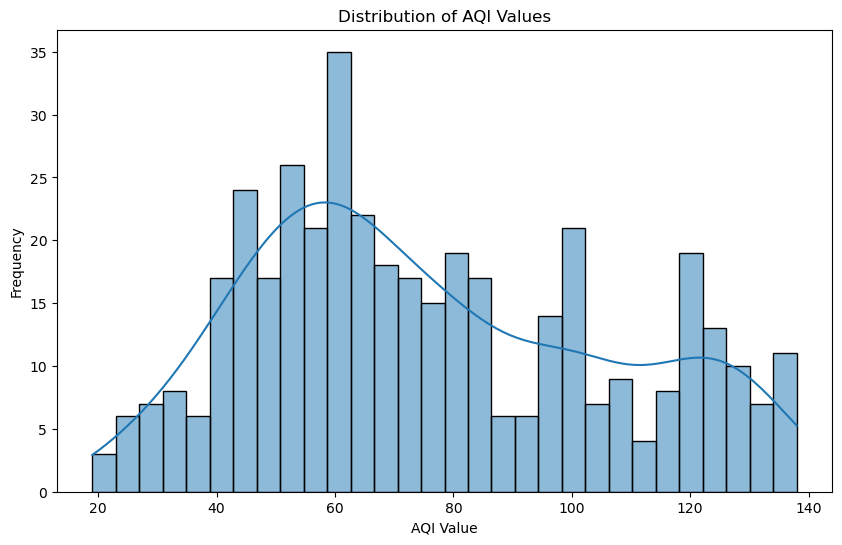

In [94]:
# Visualization 1: AQI Value Distribution (CSV Data)
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['AQI Value'], kde=True, bins=30)
plt.title('Distribution of AQI Values')
plt.xlabel('AQI Value')
plt.ylabel('Frequency')
plt.savefig('visualization_1.png')
plt.show()

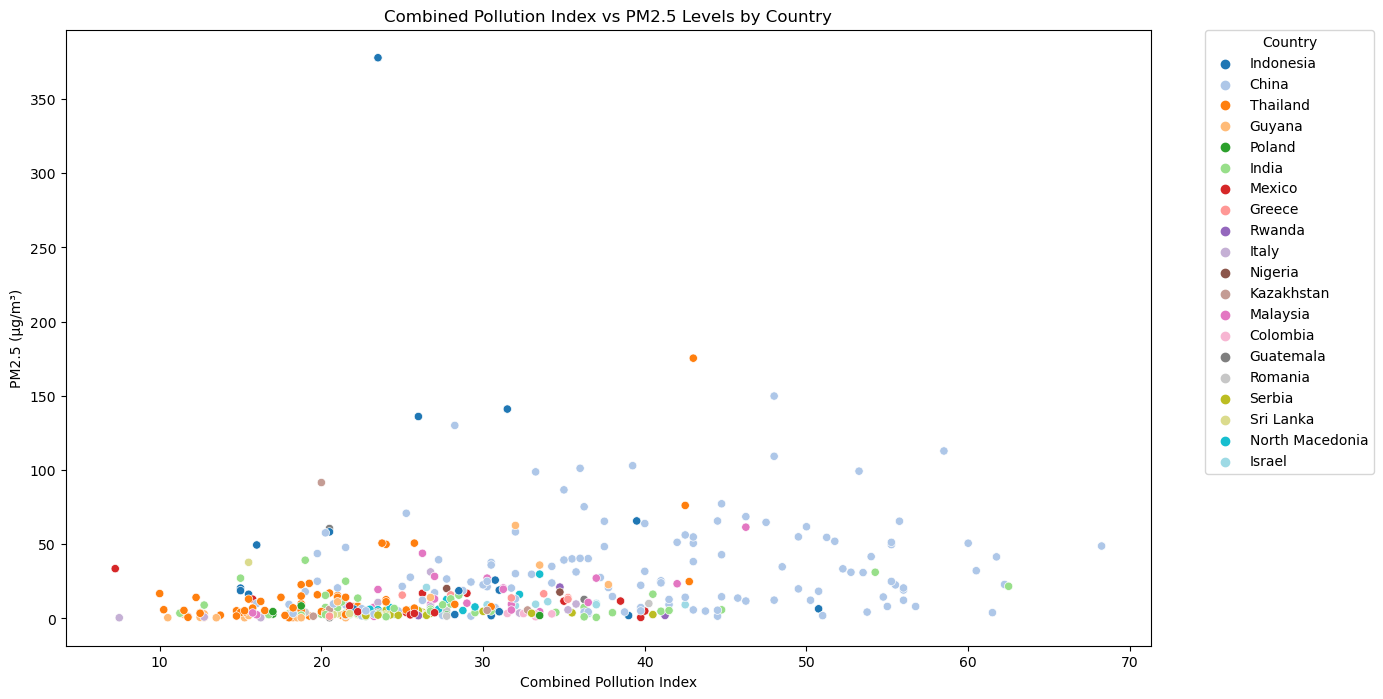

In [95]:
# Visualization 2: Combined Pollution Index vs PM2.5 Levels (Using CSV and API Data)
plt.figure(figsize=(14, 8))
sns.scatterplot(data=common_entries_clean, x='Combined Pollution Index', y='pm2_5', hue='Country', legend='full', palette='tab20')
plt.title('Combined Pollution Index vs PM2.5 Levels by Country')
plt.xlabel('Combined Pollution Index')
plt.ylabel('PM2.5 (µg/m³)')

# Adjust legend
handles, labels = plt.gca().get_legend_handles_labels()
# Select the first 20 items (or however many you find appropriate)
n = 20
plt.legend(handles[:n], labels[:n], title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig('visualization_combined_pollution_vs_pm25.png')
plt.show()

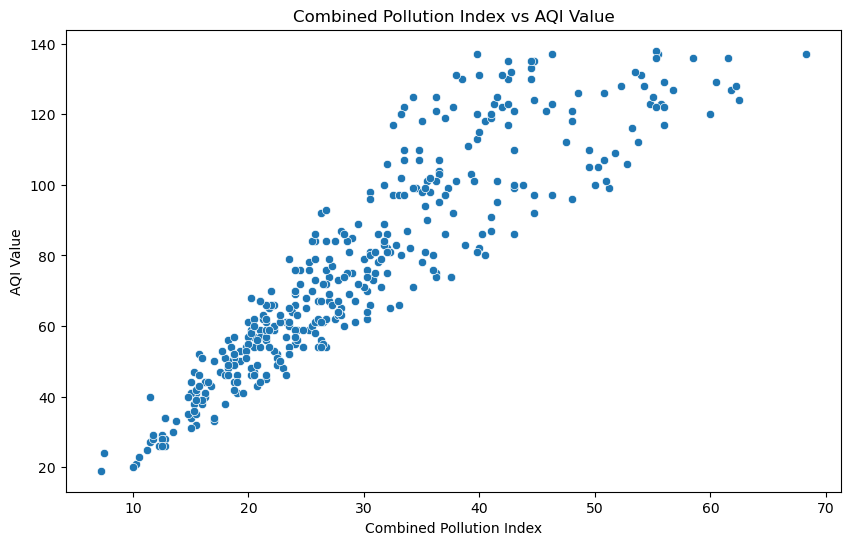

In [96]:
# Visualization 3: Combined Pollution Index vs AQI Value (CSV Data)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=common_entries_clean, x='Combined Pollution Index', y='AQI Value')
plt.title('Combined Pollution Index vs AQI Value')
plt.xlabel('Combined Pollution Index')
plt.ylabel('AQI Value')
plt.savefig('visualization_3.png')
plt.show()

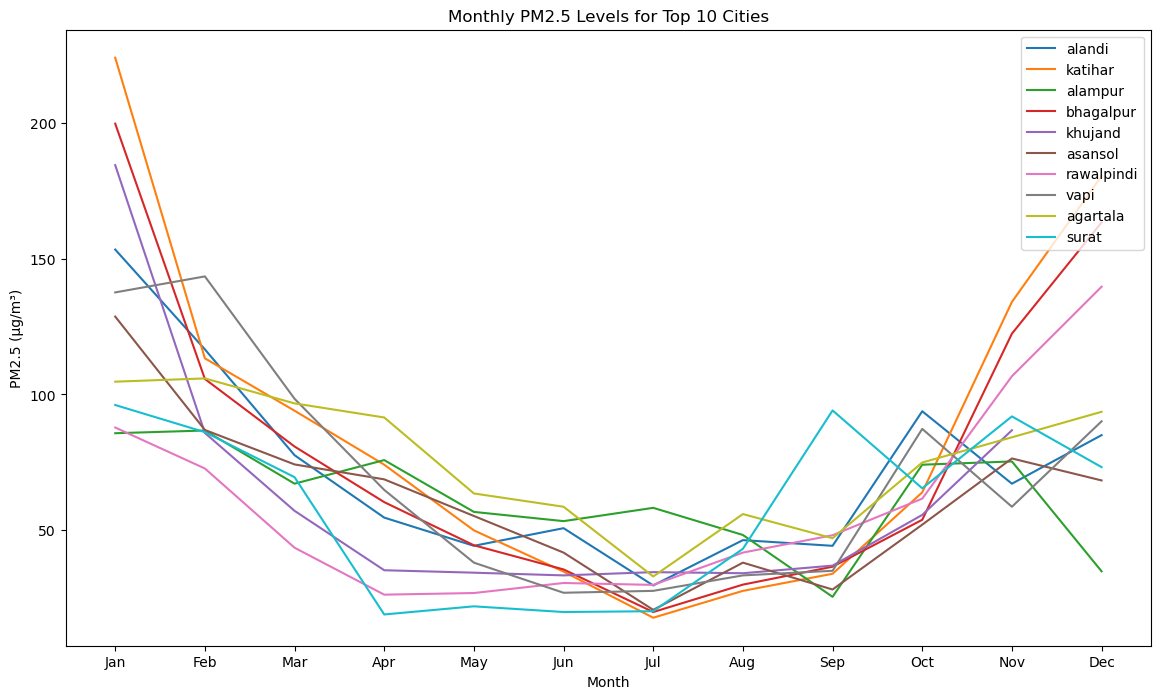

In [98]:
# Ensure 'top50_city' has no duplicates and contains the necessary monthly columns
top_cities_clean = common_entries_clean[['topcity_city', 'Country', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].drop_duplicates()
top_cities_clean.set_index(['topcity_city', 'Country'], inplace=True)
top_cities = top_cities_clean.stack().reset_index()
top_cities.columns = ['City', 'Country', 'Month', 'PM2.5']

# Subsetting to top 10 cities based on PM2.5 levels
top_10_cities = top_cities.groupby('City')['PM2.5'].mean().nlargest(10).index
filtered_top_cities = top_cities[top_cities['City'].isin(top_10_cities)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_top_cities, x='Month', y='PM2.5', hue='City')
plt.title('Monthly PM2.5 Levels for Top 10 Cities')
plt.xlabel('Month')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend(loc='upper right')
plt.savefig('visualization_4_subset.png')
plt.show()

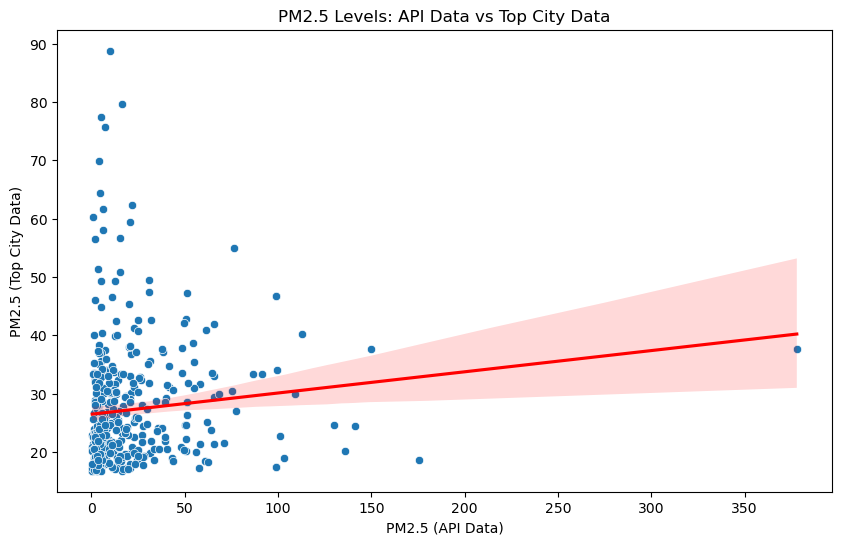

In [100]:
# Visual 5: PM2.5 Levels ( API Data and Topcity Data)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='pm2_5', y='topcity_pm25_2023')
sns.regplot(data=df_merged, x='pm2_5', y='topcity_pm25_2023', scatter=False, color='red')
plt.title('PM2.5 Levels: API Data vs Top City Data')
plt.xlabel('PM2.5 (API Data)')
plt.ylabel('PM2.5 (Top City Data)')
plt.savefig('visualization_5.png')
plt.show()

            pm2_5  topcity_pm25_2023
count  413.000000         413.000000
mean    20.550339          27.232446
std     31.284351          10.658864
min      0.500000          16.800000
25%      3.800000          19.700000
50%      9.590000          24.200000
75%     23.930000          31.200000
max    377.890000          88.800000


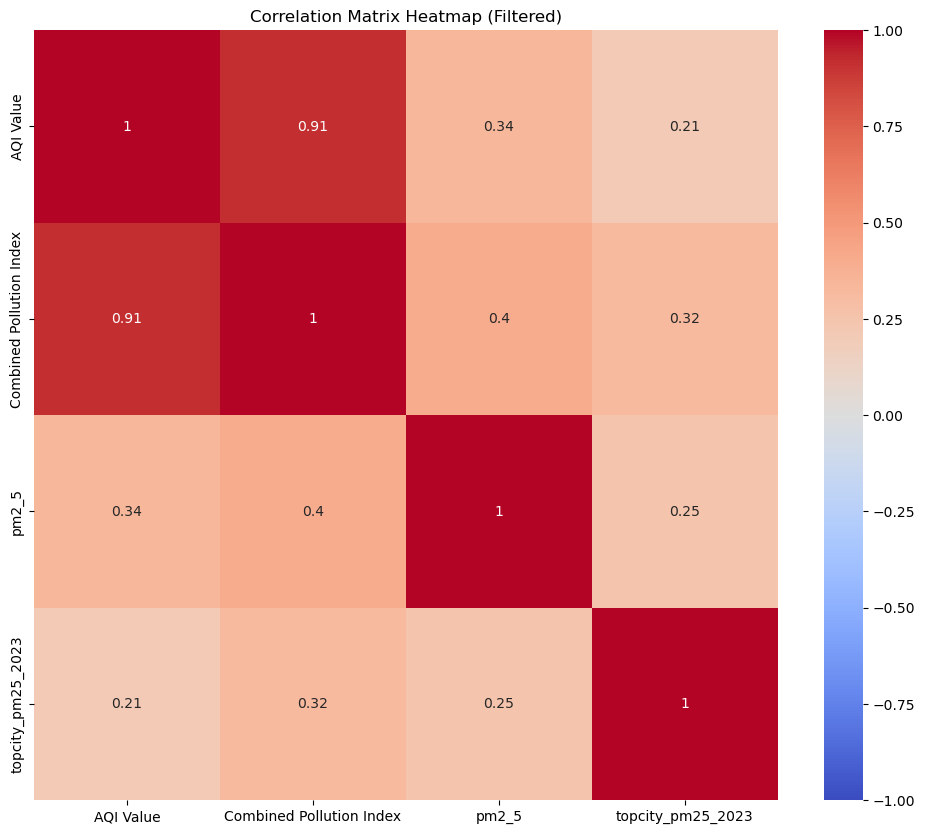

In [103]:
# Visual 6: Correlation Heatmap (CSV, Top City, API data)
# Check summary statistics to understand the data distribution
print(df_merged[['pm2_5', 'topcity_pm25_2023']].describe())

# Identify and remove outliers (optional, based on your data understanding)
Q1 = df_merged[['pm2_5', 'topcity_pm25_2023']].quantile(0.25)
Q3 = df_merged[['pm2_5', 'topcity_pm25_2023']].quantile(0.75)
IQR = Q3 - Q1

filtered_df = df_merged[~((df_merged[['pm2_5', 'topcity_pm25_2023']] < (Q1 - 1.5 * IQR)) |(df_merged[['pm2_5', 'topcity_pm25_2023']] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Recreate the correlation matrix heatmap after filtering outliers
correlation_matrix = filtered_df[['AQI Value', 'Combined Pollution Index', 'pm2_5', 'topcity_pm25_2023']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap (Filtered)')
plt.show()

# Summary of the Project
During this project, I engaged in the process of cleaning, transforming, and merging multiple datasets related to air quality and pollution. The primary sources included a CSV file detailing global air pollution data, a website listing the most polluted countries and cities, and real-time pollution data fetched from the OpenWeatherMap API. Each dataset presented unique challenges and required specific data wrangling techniques to ensure consistency and usability.

Firstly, the CSV dataset was cleaned by addressing missing values, standardizing text fields, removing duplicates, and identifying outliers. These steps ensured that the data was accurate and ready for analysis. The data from the website was scraped, and similar cleaning steps were applied, including converting textual data to numeric formats and splitting combined city and country fields for better clarity. For the API data, additional steps were taken to fetch real-time pollution data based on latitude and longitude coordinates for the matched entries from the other datasets.

The merged dataset was then stored in an SQLite database, leveraging SQL's efficient join operations to combine the different sources into a single comprehensive dataset. This merged dataset provided a robust foundation for further analysis and visualization, demonstrating the importance of meticulous data preparation in data science projects.

## Ethical Implications of Data Wrangling
#### Changes Made to the Data:
Several transformations were applied, including filling missing values, standardizing text fields, removing duplicates, identifying outliers, and converting data types. These changes were necessary to ensure the data's integrity and usability.

#### Legal and Regulatory Guidelines:
While the datasets used did not fall under stringent regulatory guidelines specific to personal data, environmental data reporting must adhere to standards that ensure accuracy and transparency. This is crucial as the data can influence public perception and policy decisions regarding air quality.

#### Risks Created by Transformations:
The transformations could introduce biases, particularly through assumptions made during data imputation and outlier removal. Misrepresenting air quality trends or oversimplifying data could lead to misleading conclusions and potentially affect public health decisions.

#### Assumptions in Data Cleaning/Transforming:
Assumptions were made during data imputation, such as filling missing values with placeholders or medians. While these methods are standard, they carry the risk of distorting the data's true representation if not carefully considered.

#### Data Sourcing and Verification:
The data was sourced from reputable platforms like Kaggle, IQAir, and OpenWeatherMap. These sources are known for their credibility in environmental monitoring, providing a level of confidence in the data's accuracy.

#### Ethical Data Acquisition:
The data was acquired through publicly accessible platforms, adhering to their usage policies. No private or sensitive information was accessed, ensuring ethical data handling.

### Mitigating Ethical Implications:
To mitigate ethical concerns, transparency in the data cleaning process is crucial. Documenting each transformation step, providing access to both raw and processed data, and ensuring the reproducibility of the analysis helps maintain trust. Additionally, verifying the changes against other reputable sources can validate the modifications and ensure the data's integrity.

In conclusion, this project underscored the importance of thorough data cleaning and ethical considerations in data science. By meticulously preparing the data and adhering to ethical guidelines, we tried to ensure the reliability and validity of our analyses, fostering informed decision-making and public trust in the results. This comprehensive approach not only enhances the quality of the insights derived from the datasets but also upholds the ethical standards essential in data-driven research.

